## Instala los paquetes

In [ ]:
!pip install Clustimage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 10.7 MB/s eta 0:00:00


## Descarga las imágenes

#Link al dataset = https://www.muratkoklu.com/datasets/vtdhnd09.php
#Si se pullea hay que bajar las imagenes y crear una carpeta Img con los 5 tipos separados

In [ ]:
!wget https://www.muratkoklu.com/datasets/vtdhnd09.php -P ./datasets/
!unzip ./datasets/vtdhnd09.php -d ./datasets

In [ ]:
!rm datasets/Rice_Image_Dataset/Rice_Citation_Request.txt

In [ ]:
from pathlib import Path
from clustimage import Clustimage
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np
from PIL import Image
from scipy.ndimage import median_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import maximum_filter
from matplotlib import cm
from collections import OrderedDict
import pickle

N_IMAGES = 1000
SEED = 42

In [ ]:
#Defino funciones:

#Funcion para leer los archivos, lee ".png" por defecto
def leer_img(img_path,formato=".png"):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path

#Funcion para verificar que los archivos sean todos del mismo tamaño (tamaño por defecto 128,128,3)
def ver_tam(ubicacion, size=(128,128,3),max=255):
  '''Función para verificar el tamaño de los archivos
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  size(tupla, por defecto 128,128,3) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).shape != size]
  if diferentes == []:
    print("Los tamaños son: ", size)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).shape)
    return diferentes

def r_max_min(ubicacion, rango=[0,255]): #Revisar esto y sumar max y min para que sea univoco
  '''Función para verificar el el valor máximo de las matrices
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  max(int, por defecto 255) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).max() > max(rango) or cv2.imread(x).min() < min(rango) ]
  if diferentes == []:
    print("El valor máximo es menor o igual: ", rango)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).min(), cv2.imread(dife).max())
    return diferentes

def sum_sse(KM):
  '''Suma cuadrada usando la .inertia_ del modelo'''
  sse = 0
  sse = (KM.inertia_)
  return sse


def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
dir_path = Path("./datasets/Rice_Image_Dataset/")

In [ ]:
def leer_nimg(img_path,formato=".png",n=100):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  largo = len(path)
  if n<largo:
      path = path[:n]
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path


completo = []
for ct,directorio in enumerate(os.listdir(dir_path)):
    path = leer_nimg(Path(dir_path / directorio),".jpg",N_IMAGES)
    completo += path

Numero de imagenes cargadas:  1000
Path obtenido:  datasets/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  datasets/Rice_Image_Dataset/Arborio/Arborio (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  datasets/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  datasets/Rice_Image_Dataset/Basmati/Basmati (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  datasets/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg


In [ ]:
#Verificamos el tamño de las imagenes
size = (250,250,3)
diferentes = ver_tam(completo,size)
#Verificamos el si los valores se encuentran en rango
#ranguera = [0,255]
#max_val = r_max_min(path,ranguera)

Los tamaños son:  (250, 250, 3)


In [ ]:
tipos = ["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

para_labels = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels += temp*N_IMAGES


In [ ]:
len(para_labels)

5000

In [ ]:
df_paths = pd.DataFrame(completo)

In [ ]:
df_paths.head()

,0
0,datasets/Rice_Image_Dataset/Karacadag/Karacada...
1,datasets/Rice_Image_Dataset/Karacadag/Karacada...
2,datasets/Rice_Image_Dataset/Karacadag/Karacada...
3,datasets/Rice_Image_Dataset/Karacadag/Karacada...
4,datasets/Rice_Image_Dataset/Karacadag/Karacada...


In [ ]:
df_paths = df_paths.rename(columns={0:"ubica"})
df_paths["file"] = df_paths["ubica"].str.split('/').str.get(-1)

In [ ]:
df_paths["label"] = para_labels
df_combi = df_paths

In [ ]:
tipos = ["0","1","2","3","4"]

para_labels_num = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels_num += temp*N_IMAGES

df_combi["label_num"] = para_labels_num

df_combi["label_num"] = df_combi["label_num"].astype('int64')

df_combi

,ubica,file,label,label_num
0,datasets/Rice_Image_Dataset/Karacadag/Karacada...,Karacadag (1).jpg,Arborio,0
1,datasets/Rice_Image_Dataset/Karacadag/Karacada...,Karacadag (10).jpg,Arborio,0
2,datasets/Rice_Image_Dataset/Karacadag/Karacada...,Karacadag (100).jpg,Arborio,0
3,datasets/Rice_Image_Dataset/Karacadag/Karacada...,Karacadag (1000).jpg,Arborio,0
4,datasets/Rice_Image_Dataset/Karacadag/Karacada...,Karacadag (10000).jpg,Arborio,0
...,...,...,...,...
4995,datasets/Rice_Image_Dataset/Ipsala/Ipsala (108...,Ipsala (10894).jpg,Karacadag,4
4996,datasets/Rice_Image_Dataset/Ipsala/Ipsala (108...,Ipsala (10895).jpg,Karacadag,4
4997,datasets/Rice_Image_Dataset/Ipsala/Ipsala (108...,Ipsala (10896).jpg,Karacadag,4
4998,datasets/Rice_Image_Dataset/Ipsala/Ipsala (108...,Ipsala (10897).jpg,Karacadag,4


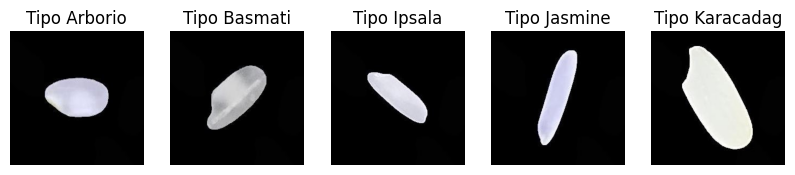

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(10, 10))
for ct,i in enumerate(df_combi["label"].unique()):
  testeo = df_combi[df_combi.label == i]
  ubica = testeo.sample().ubica.iloc[0]
  img = Image.open(ubica)
  axs[ct].imshow(img)
  axs[ct].set_title(f'Tipo {i}')
  axs[ct].axis('off')
#fig.tight_layout(h_pad=-20, w_pad=1)

In [ ]:
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

553467096/553467096 [==============================] - 7s 0us/step


In [ ]:
def preprocess(lista, model):
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress
    # lista de filenames
    filenmss = np.array(list(datays.keys()))

    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens
    print(featsss.shape)
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

def extract_features(file, model):
    # levanta imagen como array 224x224
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image')
    img = np.array(img)
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

In [ ]:
import matplotlib.cm as cm

def grafica_silhouette(KM,d):
  silhouette_avg = silhouette_score(d,KM.labels_,metric='euclidean')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='euclidean')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title(("Silhouette analysis for KMeans clustering on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

In [ ]:
names, feat = preprocess(completo, model)

In [ ]:
#Guardo en pickle el modelo
pickle.dump(names, open('names-5k-img.pk1','wb'))
pickle.dump(feat, open('feat-5k-img.pk1','wb'))

#Cargo el modelo
#names = pickle.load(open('names-5k-img.pk1','rb'))
#feat = pickle.load(open('feat-5k-img.pk1','rb'))


In [ ]:
# get the unique labels (from the flower_labels.csv)

label = df_combi['label'].tolist()
unique_labels = list(set(label))
unique_labels

['Karacadag', 'Arborio', 'Basmati', 'Jasmine', 'Ipsala']

In [ ]:
pca = PCA(n_components=100, random_state=SEED)
pca.fit(feat)
x = pca.transform(feat)

In [ ]:
#No funciona
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE
tsne = TSNE(n_components=2,perplexity=500, n_iter=1000)
Xred = tsne.fit_transform(feat)
plt.scatter(Xred[:,0],Xred[:,1],c=y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

NameError: ignored

In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)

In [ ]:
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

In [ ]:
#Kmeans básico:
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,0].set_xlim([0,15])
axs[0,0].set_xlabel('PCs')
axs[0,0].set_ylabel('Var. explicada (%)')
axs[0,0].set_title("Variabilidad explicada en (%)")
axs[0,1].axis('off')

axs[1,0].scatter(x[:,0],x[:,1],s=5,c=kmeans.labels_, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,0].set_title("Labels obtenidas en las PC1 y PC2")
axs[1,1].scatter(x[:,2],x[:,3],s=5,c=kmeans.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')
axs[1,1].set_title("Labels obtenidas en las PC3 y PC4")
axs[2,0].scatter(x[:,0],x[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('PC1')
axs[2,0].set_ylabel('PC2')
axs[2,0].set_title("Labels reales en las PC1 y PC2")
axs[2,1].scatter(x[:,2],x[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')
axs[2,1].set_title("Labels reales en las PC3 y PC4")

fig.suptitle("Kmeans básico", fontsize=36)

In [ ]:
test = df_combi[["label_num","label"]]

In [ ]:
test["x"] = x[:,0]
test["y"] = x[:,1]

In [ ]:
test_1_2 = test[(test["label_num"] == 1) | (test["label_num"] == 2) | (test["label_num"] == 3) | (test["label_num"] == 4) ]
test_1_2

In [ ]:
test_modelo = KMeans(n=4)

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].scatter(test_1_2["x"],test_1_2["y"],s=5,c=test_1_2["label_num"], alpha=0.5)
axs[0,0].set_xlabel('PC1')
axs[0,0].set_ylabel('PC2')

axs[0,1].scatter(test_1_2["x"],test_1_2["y"],s=5,c=df_combi["label_num"], alpha=0.5)
axs[0,1].set_xlabel('PC1')
axs[0,1].set_ylabel('PC2')

In [ ]:
#Kmeans básico:
fig, axs = plt.subplots(3,2,figsize=(15,15))
#axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,0].set_xlim([0,15])
axs[0,0].set_xlabel('PCs')
axs[0,0].set_ylabel('Var. explicada (%)')
axs[0,0].set_title("Variabilidad explicada en (%)")
axs[0,1].axis('off')

axs[1,0].scatter(Xred[:,0],Xred[:,1],s=5,c=kmeans.labels_, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,0].set_title("Labels obtenidas en las PC1 y PC2")
axs[1,1].scatter(Xred[:,2],Xred[:,3],s=5,c=kmeans.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')
axs[1,1].set_title("Labels obtenidas en las PC3 y PC4")
axs[2,0].scatter(Xred[:,0],Xred[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('PC1')
axs[2,0].set_ylabel('PC2')
axs[2,0].set_title("Labels reales en las PC1 y PC2")
axs[2,1].scatter(Xred[:,2],Xred[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')
axs[2,1].set_title("Labels reales en las PC3 y PC4")

fig.suptitle("Kmeans básico", fontsize=36)

In [ ]:
#Puntajes obtenidos

from sklearn.metrics import silhouette_samples, silhouette_score


range_k = range(2,10)
silh = []
sse = []
for k in range_k:
    model_calc = KMeans(n_clusters=k).fit(x)
    silh.append(silhouette_score(x,model_calc.labels_))
    sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()


In [ ]:
k = 5
grafica_silhouette(kmeans,x)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
print("Rand score ajustado: ",adjusted_rand_score(df_combi["label_num"],kmeans.labels_))
#vanDongen
df_combi["predicted"] = kmeans.labels_

df_van = df_combi[["label_num","predicted"]]
print("vanDongen: ",vanDongen(df_van))

In [ ]:
# Segundo modelo Kmedoids
from sklearn_extra.cluster import KMedoids
KM_meta=KMedoids(n_clusters=5,init='k-medoids++').fit(x)

In [ ]:
#KMedoids:
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,0].set_xlim([0,15])
axs[0,0].set_xlabel('PCs')
axs[0,0].set_ylabel('Var. explicada (%)')
axs[0,1].axis('off')

axs[1,0].scatter(x[:,0],x[:,1],s=5,c=KM_meta.labels_, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,0].set_title("Labels obtenidas en las PC1 y PC2")
axs[1,1].scatter(x[:,2],x[:,3],s=5,c=KM_meta.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')
axs[1,1].set_title("Labels obtenidas en las PC3 y PC4")
axs[2,0].scatter(x[:,0],x[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('PC1')
axs[2,0].set_ylabel('PC2')
axs[2,0].set_title("Labels reales en las PC1 y PC2")
axs[2,1].scatter(x[:,2],x[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')
axs[2,1].set_title("Labels reales en las PC3 y PC4")

fig.suptitle("KMedoids 5 clusters", fontsize=36)



In [ ]:
range_k = range(2,12)
silh = []
sse = []
for k in range_k:
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    model_calc = KMedoids(n_clusters=k,init='heuristic').fit(x)
    silh.append(silhouette_score(x,model_calc.labels_))
    sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()



In [ ]:
k = 5
grafica_silhouette(KM_meta,x)

In [ ]:
print("Rand score ajustado: ",adjusted_rand_score(df_combi["label_num"],KM_meta.labels_))
#vanDongen
df_combi["predicted"] = KM_meta.labels_

df_van = df_combi[["label_num","predicted"]]
print("vanDongen: ",vanDongen(df_van))

In [ ]:
from sklearn.cluster import BisectingKMeans

biskmeans = BisectingKMeans(n_clusters=5).fit(x)

#AgglomerativeClustering:
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,0].set_xlim([0,15])
axs[0,0].set_xlabel('PCs')
axs[0,0].set_ylabel('Var. explicada (%)')
axs[0,1].axis('off')

axs[1,0].scatter(x[:,0],x[:,1],s=5,c=biskmeans.labels_, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,0].set_title("Labels obtenidas en las PC1 y PC2")
axs[1,1].scatter(x[:,2],x[:,3],s=5,c=biskmeans.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')
axs[1,1].set_title("Labels obtenidas en las PC3 y PC4")
axs[2,0].scatter(x[:,0],x[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('PC1')
axs[2,0].set_ylabel('PC2')
axs[2,0].set_title("Labels reales en las PC1 y PC2")
axs[2,1].scatter(x[:,2],x[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')
axs[2,1].set_title("Labels reales en las PC3 y PC4")
fig.suptitle("BisectingKMeans 5 clusters", fontsize=36)

In [ ]:
range_k = range(2,12)
silh = []
sse = []
for k in range_k:
    model_calc = BisectingKMeans(n_clusters=k).fit(x)
    silh.append(silhouette_score(x,model_calc.labels_))
    sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()




In [ ]:
k = 5
grafica_silhouette(biskmeans,x)

In [ ]:
print("Rand score ajustado: ",adjusted_rand_score(df_combi["label_num"],biskmeans.labels_))
#vanDongen
df_combi["predicted"] = biskmeans.labels_

df_van = df_combi[["label_num","predicted"]]
print("vanDongen: ",vanDongen(df_van))

In [ ]:
print(KM_meta.labels_)
print(KM_meta.medoid_indices_)
print(silhouette_score(x,KM_meta.labels_))
print(sum_sse(KM_meta))
silhouette_samples(x,KM_meta.labels_)

In [ ]:
range_k = range(2,12)
silh = []
sse = []
for k in range_k:
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    KM_meta = KMedoids(n_clusters=k,init='heuristic').fit(x)
    silh.append(silhouette_score(x,KM_meta.labels_))
    sse.append(sum_sse(KM_meta))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()



In [ ]:
import matplotlib.cm as cm

def grafica_silhouette(KM,d):
  silhouette_avg = silhouette_score(d,KM.labels_,metric='euclidean')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='euclidean')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title(("Silhouette analysis for KMeans clustering on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

In [ ]:
k = 5
KM_meta = KMedoids(n_clusters=k,metric='euclidean',init='heuristic').fit(x)
grafica_silhouette(KM_meta,x)

In [ ]:
k = 6
KM_meta = KMedoids(n_clusters=k,metric='euclidean',init='heuristic').fit(x)
grafica_silhouette(KM_meta,x)

In [ ]:
k = 4
KM_meta = KMedoids(n_clusters=k,metric='euclidean',init='heuristic').fit(x)
grafica_silhouette(KM_meta,x)

In [ ]:
df_combi["predicted"] = KM_meta.labels_

In [ ]:
df_combi[["predicted","label_num"]]

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(df_combi["label_num"],df_combi["predicted"])

In [ ]:
#función definida
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

#vanDongen
df_van = df_combi[["label_num","predicted"]]
vanDongen(df_van)

In [ ]:
#vanDongen
df_van = df_combi[["label_num","predicted"]]
vanDongen(df_van)